In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from Utils.DataLoader import DataLoader
from Utils.DataTransformer import DataTransformer
from Utils.DuckDb.DuckDb import DuckDb
from Utils.DatasetProcessor.DatasetProcessorUtils import DatasetProcessorUtils
from Utils.DataAnalysis import DataAnalysis
from datetime import datetime
import pandas as pd
from typing import List
from Utils import PandasNotebookConfigs
import project_config
import numpy as np
import matplotlib.pyplot as plt
import joblib
from datetime import datetime
from Utils.Datetime import DatetimeUtils
from Utils.Dict import DictUtils

In [7]:
PandasNotebookConfigs.config()

Ajustando display.float.format para %.4f
Ajustando prints de linhas e colunas


In [8]:
DUCK_DB = DuckDb()
DATA_TRANSFORMER = DataTransformer()
DATA_PROCESSOR_UTILS = DatasetProcessorUtils(DUCK_DB)
DATETIME_UTILS = DatetimeUtils()
DICT_UTILS = DictUtils()
DATA_ANALYSIS = DataAnalysis()

In [9]:
# Determined by Silhouette method
HEAVY_USER_CLUSTER_NAME = 'Heavy User'
LIGHT_USER_CLUSTER_NAME = 'Light User'

In [10]:
CLUSTERS = [
    # From the heaviest to the lowest
    HEAVY_USER_CLUSTER_NAME,
    LIGHT_USER_CLUSTER_NAME
]

In [11]:
USAGE_COLUMNS = [
    'num_100', 'num_100-1M', 'num_100-2M',
    'num_25', 'num_25-1M', 'num_25-2M',
    'num_50', 'num_50-1M', 'num_50-2M',
    'num_75', 'num_75-1M', 'num_75-2M',
    'num_985', 'num_985-1M', 'num_985-2M',
    'num_unq', 'num_unq-1M', 'num_unq-2M',
    'total_secs', 'total_secs-1M', 'total_secs-2M',
    'is_churn',
]

In [12]:
df = DUCK_DB.load_table(
    project_config.PREDICTED_DATA_TABLE
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [13]:
len(df), len(df['msno'].unique())

(1251070, 299458)

In [14]:
# Group by msno and get the last register
df = df.groupby('msno').tail(1)
len(df)

299458

In [15]:
df = df[project_config.COLUMNS_USED_ON_TRAIN_AND_PREDICTION + [project_config.TARGET_COLUMN]]

In [16]:
df.head()

,registration_init_time_day,registration_init_time_day_of_year,registration_init_time_year,transaction_date_day,transaction_date_day_of_week,transaction_date_day_of_year,transaction_date_month,membership_expire_date_day,membership_expire_date_day_of_year,membership_expire_date_month,membership_expire_date_year,is_auto_renew,is_cancel,remaining_days,safra_month,num_100,num_100-1M,num_100-2M,num_25,num_25-1M,num_25-2M,num_50,num_50-1M,num_50-2M,num_75,num_75-1M,num_75-2M,num_985,num_985-1M,num_985-2M,num_unq,num_unq-1M,num_unq-2M,total_secs,total_secs-1M,total_secs-2M,city_0,city_1,city_10,city_11,city_12,city_13,city_14,city_15,city_16,city_17,city_18,city_19,city_2,city_20,city_21,city_22,city_3,city_4,city_5,city_6,city_7,city_8,city_9,registered_via_0,registered_via_1,registered_via_10,registered_via_11,registered_via_12,registered_via_13,registered_via_14,registered_via_15,registered_via_16,registered_via_17,registered_via_18,registered_via_19,registered_via_2,registered_via_3,registered_via_4,registered_via_5,registered_via_6,registered_via_7,registered_via_8,registered_via_9,payment_method_id_0,payment_method_id_1,payment_method_id_10,payment_method_id_11,payment_method_id_12,payment_method_id_13,payment_method_id_14,payment_method_id_15,payment_method_id_16,payment_method_id_17,payment_method_id_18,payment_method_id_19,payment_method_id_2,payment_method_id_20,payment_method_id_21,payment_method_id_22,payment_method_id_23,payment_method_id_24,payment_method_id_25,payment_method_id_26,payment_method_id_27,payment_method_id_28,payment_method_id_29,payment_method_id_3,payment_method_id_30,payment_method_id_31,payment_method_id_32,payment_method_id_33,payment_method_id_34,payment_method_id_35,payment_method_id_36,payment_method_id_37,payment_method_id_38,payment_method_id_39,payment_method_id_4,payment_method_id_40,payment_method_id_41,payment_method_id_5,payment_method_id_6,payment_method_id_7,payment_method_id_8,payment_method_id_9,is_churn
0,27,87,2004,9,4,253,9,14,258,9,2016,False,False,5.0000,9.0000,171,171.0000,171.0000,60,60.0000,60.0000,12,12.0000,12.0000,14,14.0000,14.0000,7,7.0000,7.0000,179,179.0000,179.0000,49996,49996.0000,49996.0000,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True
4,8,159,2014,15,2,46,2,15,74,3,2017,True,False,28.0000,2.0000,468,438.0000,855.0000,116,135.0000,193.0000,61,69.0000,88.0000,58,78.0000,98.0000,114,147.0000,142.0000,642,696.0000,979.0000,156533,157868.0000,256812.0000,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
9,18,322,2010,31,1,31,1,19,78,3,2017,True,False,47.0000,1.0000,715,533.0000,520.0000,108,43.0000,59.0000,36,25.0000,23.0000,30,24.0000,11.0000,75,96.0000,21.0000,840,676.0000,545.0000,198105,154978.0000,133337.0000,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [17]:
# test_df = df[:10_000].copy()
test_df = df.copy()

In [18]:
usage_df = test_df[USAGE_COLUMNS]

In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=len(CLUSTERS), random_state=42)
customer_clusters = kmeans.fit_predict(usage_df)

In [20]:
# Assign cluster labels to the DataFrame
usage_df['cluster'] = kmeans.labels_

# View centroids (cluster centers)
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=usage_df.columns[:-1])  # Exclude the cluster column
print("Cluster Centroids:")
print(centroids)

Cluster Centroids:
    num_100  num_100-1M  num_100-2M   num_25  num_25-1M  num_25-2M  num_50  \
0  190.5840    214.9405    214.9183  59.8414    68.2527    69.5916 14.6435   
1 1079.2923   1181.6117   1169.9854 186.1644   214.0774   219.0783 45.3388   

   num_50-1M  num_50-2M  num_75  num_75-1M  num_75-2M  num_985  num_985-1M  \
0    16.5279    16.9720  8.8892    10.1484    10.3275   9.4617     10.8123   
1    51.1308    52.3587 29.8603    33.7953    34.2912  34.8255     38.9606   

   num_985-2M  num_unq  num_unq-1M  num_unq-2M  total_secs  total_secs-1M  \
0     10.8095 217.2969    246.2626    247.9580  51554.6758     58300.0151   
1     39.0876 977.7066   1081.7673   1079.2736 280511.9173    308109.7402   

   total_secs-2M  is_churn  
0     58486.3223    0.2501  
1    305890.1554    0.1080  


/tmp/ipykernel_16629/2243360524.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usage_df['cluster'] = kmeans.labels_


In [21]:
import numpy as np

# Compute the standard deviation of each feature across clusters
feature_importance = centroids.std(axis=0).sort_values(ascending=False)

# Get the top 10 features
top_10_features = feature_importance.head(10)
print("Top 10 Features Differentiating the Clusters:")
print(top_10_features)


Top 10 Features Differentiating the Clusters:
total_secs-1M   176642.1506
total_secs-2M   174940.9280
total_secs      161897.2181
num_100-1M         683.5398
num_100-2M         675.3345
num_100            628.4117
num_unq-1M         590.7910
num_unq-2M         587.8289
num_unq            537.6909
num_25-2M          105.7031
dtype: float64


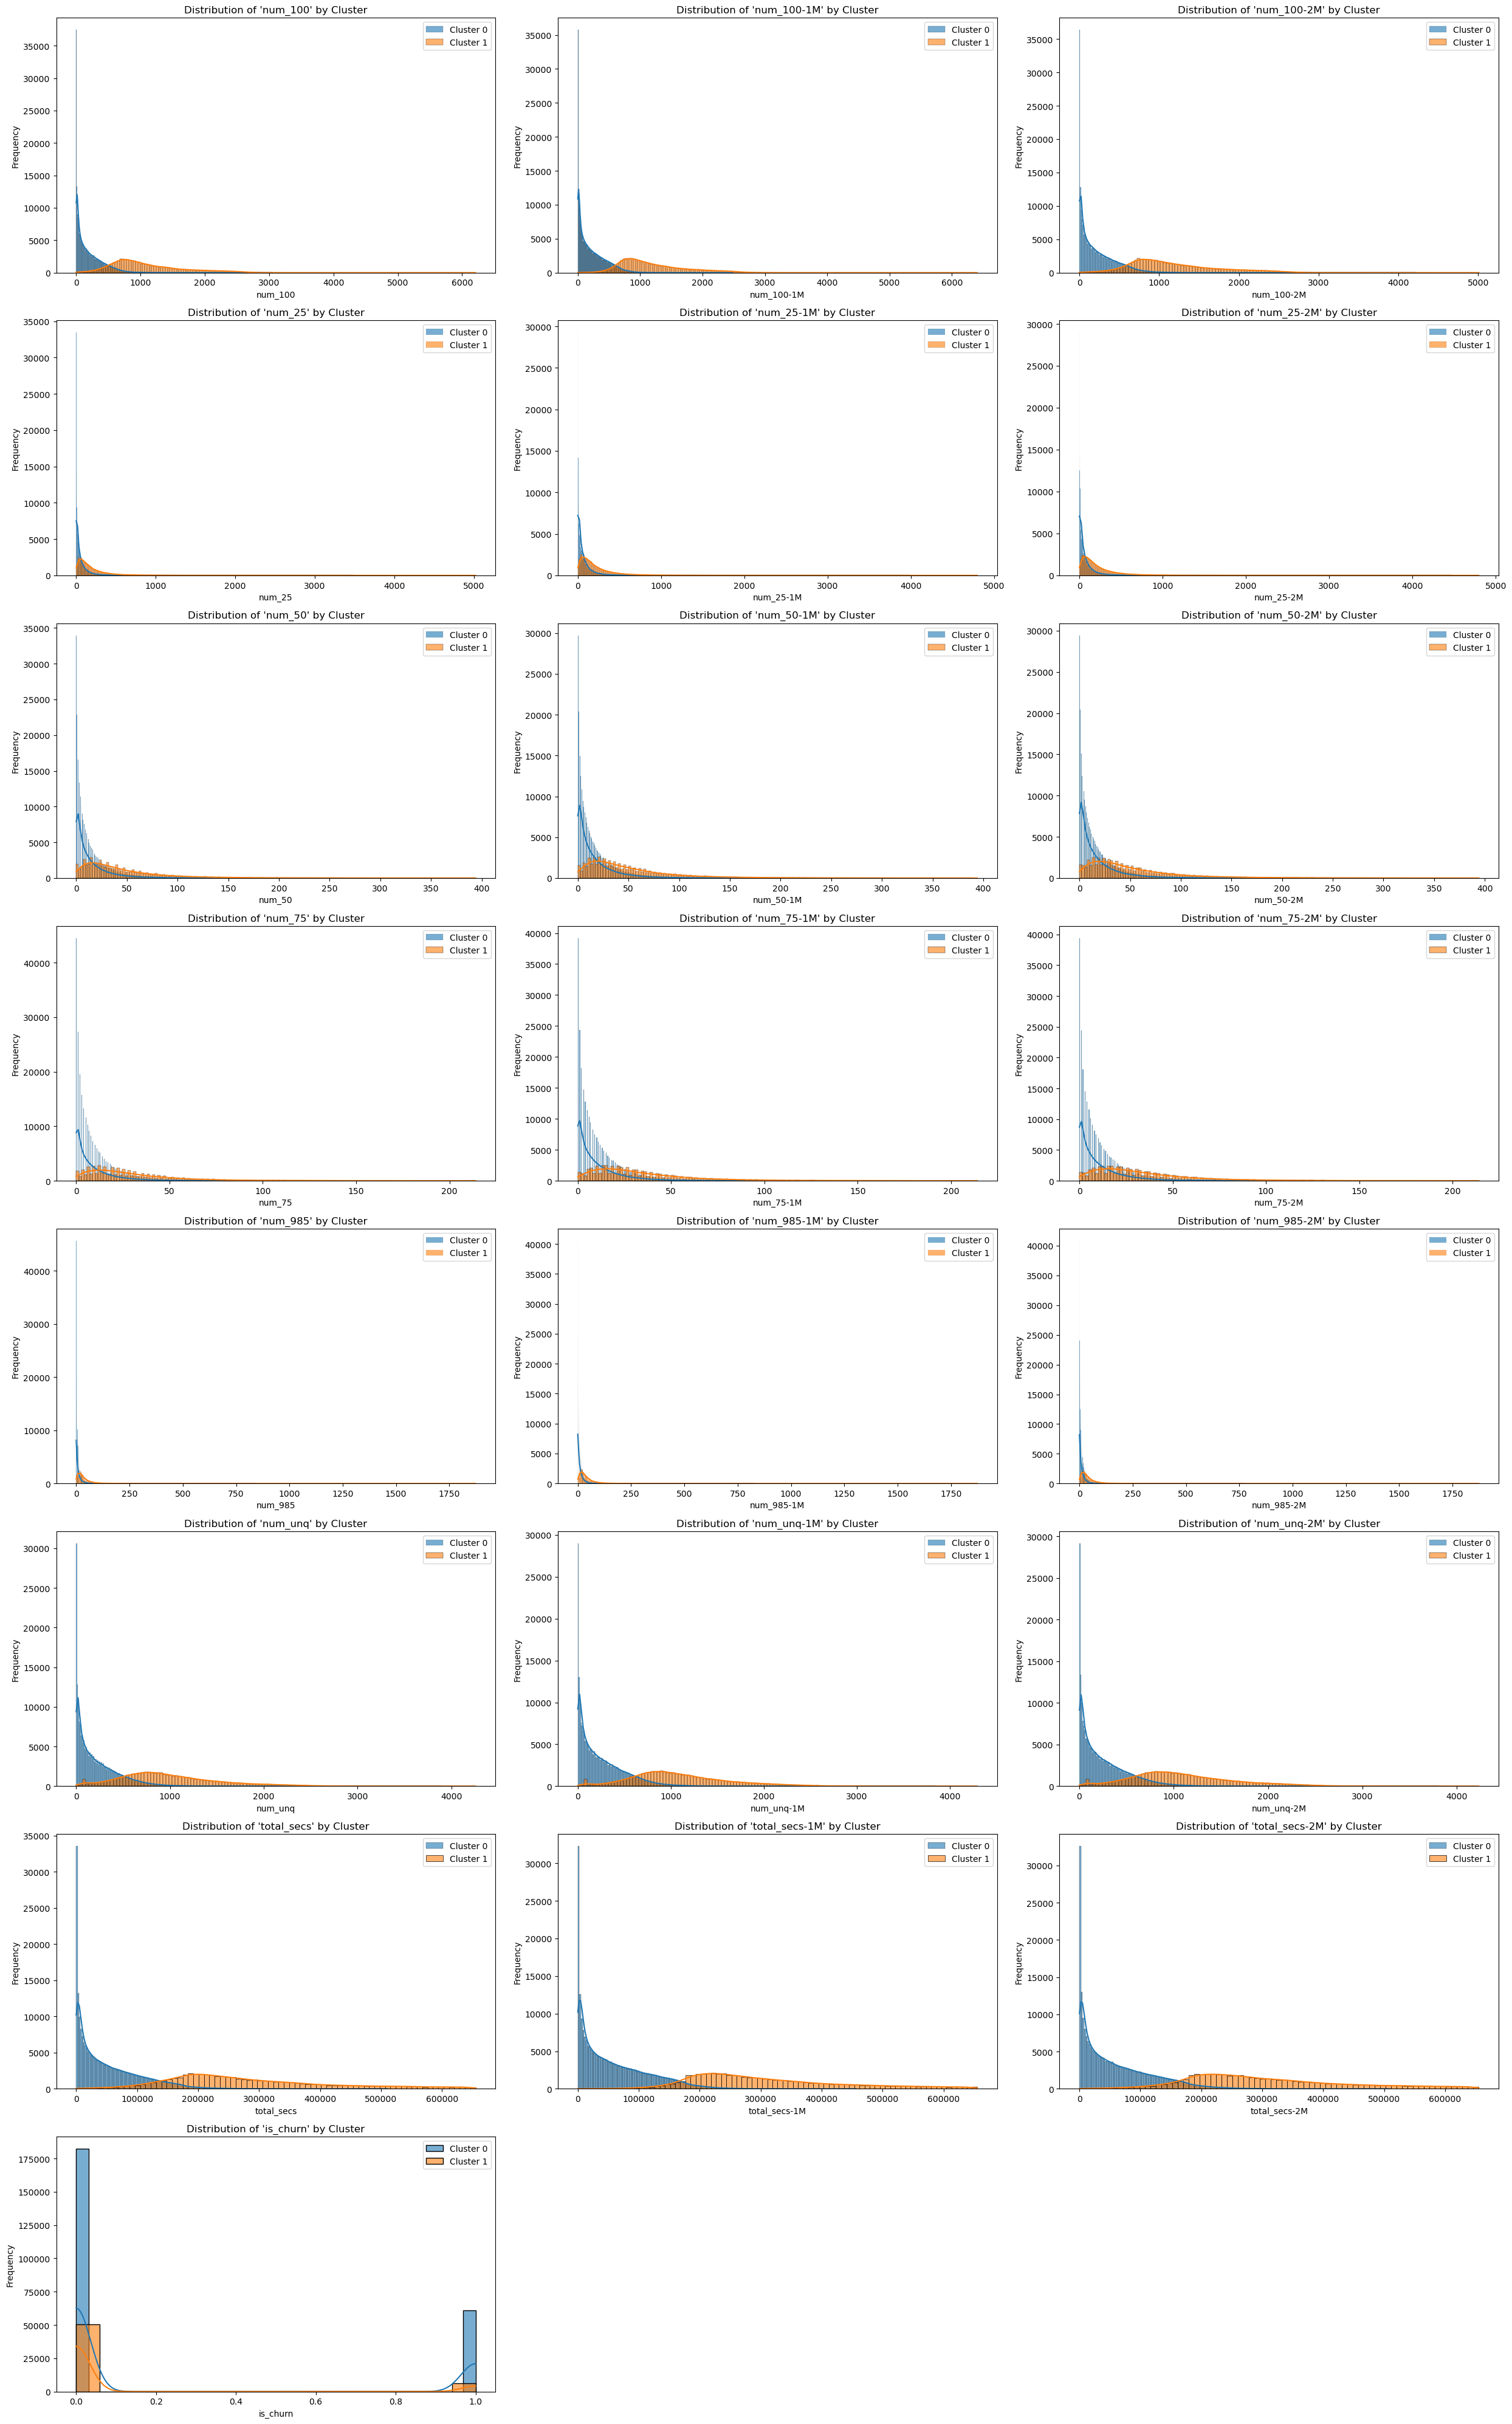

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Extract features (excluding 'cluster') and define the number of rows/columns
features = usage_df.drop('cluster', axis=1).columns
n_features = len(features)
n_cols = 3  # Number of figures per row
n_rows = math.ceil(n_features / n_cols)  # Calculate the number of rows needed

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, n_rows * 5))  # Adjust the figure size
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Iterate through each feature and create a histogram
for i, feature in enumerate(features):
    ax = axes[i]
    for cluster_id in usage_df['cluster'].unique():
        sns.histplot(
            data=usage_df[usage_df['cluster'] == cluster_id],
            x=feature,
            kde=True,
            label=f'Cluster {cluster_id}',
            alpha=0.6,
            ax=ax  # Specify the subplot for this feature
        )
    ax.set_title(f"Distribution of '{feature}' by Cluster")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequency")
    ax.legend()

# Hide unused subplots if the number of features is not a multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [23]:
from typing import Dict


def get_cluster_value_map(df: pd.DataFrame) -> Dict[str, any]:
    field_to_consider = 'total_secs'

    # Order clusters by total_secs mean value
    cluster_mean_total_secs = {}
    for i in range(0, len(CLUSTERS)):
        cluster_df = df[df['cluster'] == i]
        cluster_mean_total_secs[i] = cluster_df[field_to_consider].mean()

    cluster_mean_total_secs = DICT_UTILS.sort_dict_by_values(cluster_mean_total_secs)

    cluster_names = {}
    sorted_clusters_keys = list(cluster_mean_total_secs.keys())
    sorted_clusters_keys.reverse()
    for index, key in enumerate(sorted_clusters_keys):
        # print(f'Cluster {key} = {CLUSTERS[index]}')
        cluster_names[key] = CLUSTERS[index]

    return cluster_names

In [24]:
# Giving names to clusters
def name_clusters(df: pd.DataFrame) -> pd.DataFrame:
    cluster_names = get_cluster_value_map(df)

    # Filling out the cluster_named column
    col_data = []
    for _, row in usage_df.iterrows():
        row_cluster = row['cluster']

        col_data.append(cluster_names[row_cluster])

    df['cluster_named'] = col_data
    return df

In [25]:
usage_df = name_clusters(usage_df)

/tmp/ipykernel_16629/3569267362.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster_named'] = col_data


In [26]:
usage_df.head(20)

,num_100,num_100-1M,num_100-2M,num_25,num_25-1M,num_25-2M,num_50,num_50-1M,num_50-2M,num_75,num_75-1M,num_75-2M,num_985,num_985-1M,num_985-2M,num_unq,num_unq-1M,num_unq-2M,total_secs,total_secs-1M,total_secs-2M,is_churn,cluster,cluster_named
0,171,171.0000,171.0000,60,60.0000,60.0000,12,12.0000,12.0000,14,14.0000,14.0000,7,7.0000,7.0000,179,179.0000,179.0000,49996,49996.0000,49996.0000,True,0,Light User
4,468,438.0000,855.0000,116,135.0000,193.0000,61,69.0000,88.0000,58,78.0000,98.0000,114,147.0000,142.0000,642,696.0000,979.0000,156533,157868.0000,256812.0000,False,1,Heavy User
9,715,533.0000,520.0000,108,43.0000,59.0000,36,25.0000,23.0000,30,24.0000,11.0000,75,96.0000,21.0000,840,676.0000,545.0000,198105,154978.0000,133337.0000,False,0,Light User
15,383,651.0000,579.0000,188,289.0000,166.0000,80,175.0000,73.0000,46,97.0000,49.0000,46,82.0000,43.0000,551,1088.0000,645.0000,123768,215757.0000,169086.0000,False,0,Light User
21,258,384.0000,483.0000,103,54.0000,86.0000,47,9.0000,24.0000,27,8.0000,28.0000,32,21.0000,23.0000,194,130.0000,342.0000,78863,106043.0000,132765.0000,False,0,Light User
26,176,190.0000,91.0000,88,58.0000,49.0000,19,24.0000,11.0000,14,13.0000,8.0000,20,11.0000,18.0000,304,270.0000,165.0000,51758,54255.0000,29430.0000,False,0,Light User
29,183,183.0000,183.0000,14,14.0000,14.0000,1,1.0000,1.0000,5,5.0000,5.0000,0,0.0000,0.0000,140,140.0000,140.0000,43731,43731.0000,43731.0000,False,0,Light User
35,22,87.0000,94.0000,4,9.0000,82.0000,4,7.0000,44.0000,4,4.0000,19.0000,1,2.0000,21.0000,28,95.0000,207.0000,5712,22640.0000,33137.0000,False,0,Light User
36,24,24.0000,24.0000,6,6.0000,6.0000,1,1.0000,1.0000,1,1.0000,1.0000,0,0.0000,0.0000,20,20.0000,20.0000,6352,6352.0000,6352.0000,True,0,Light User
39,86,86.0000,86.0000,21,21.0000,21.0000,8,8.0000,8.0000,1,1.0000,1.0000,2,2.0000,2.0000,115,115.0000,115.0000,23387,23387.0000,23387.0000,False,0,Light User


In [27]:
def get_usage_info_form_clusters(df: pd.DataFrame):
    cols = [
        'total_secs',
        'num_unq'
    ]

    cluster_values_map = get_cluster_value_map(df)

    for cluster in cluster_values_map:
        grp = df[df['cluster'] == cluster]
        print(f'Cluster {cluster_values_map[cluster]}')

        for col in cols:
            print(f'\t-> Mediana de {col}: {grp[col].median()}')
            # print(f'\t-> Média de {col}: {grp[col].mean()}')
            # print()

        print()
        # print(grp)


get_usage_info_form_clusters(usage_df)

Cluster Heavy User
	-> Mediana de total_secs: 249633.0
	-> Mediana de num_unq: 895.0

Cluster Light User
	-> Mediana de total_secs: 34396.0
	-> Mediana de num_unq: 143.0



In [30]:
from typing import List

plot_pizza = DataAnalysis().plot_pizza

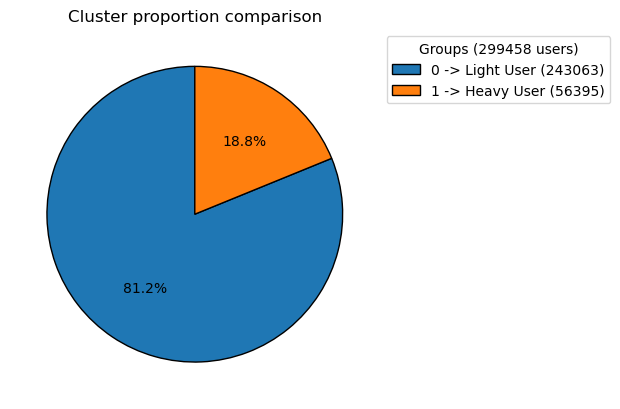

In [ ]:
def compare_cluster_proportion(df: pd.DataFrame):
    cluster_value_map = get_cluster_value_map(df)

    counted = df['cluster'].value_counts()
    labels = []
    for i in counted.index:
        labels.append(
            f'{i} -> {cluster_value_map[i]} ({counted[i]})'
        )

    plot_pizza(
        value_counts=counted,
        labels=labels,
        title='Cluster proportion comparison',
        legend=f'Groups ({len(df)} users)',
        colors=['red', 'blue']
    )

compare_cluster_proportion(usage_df)

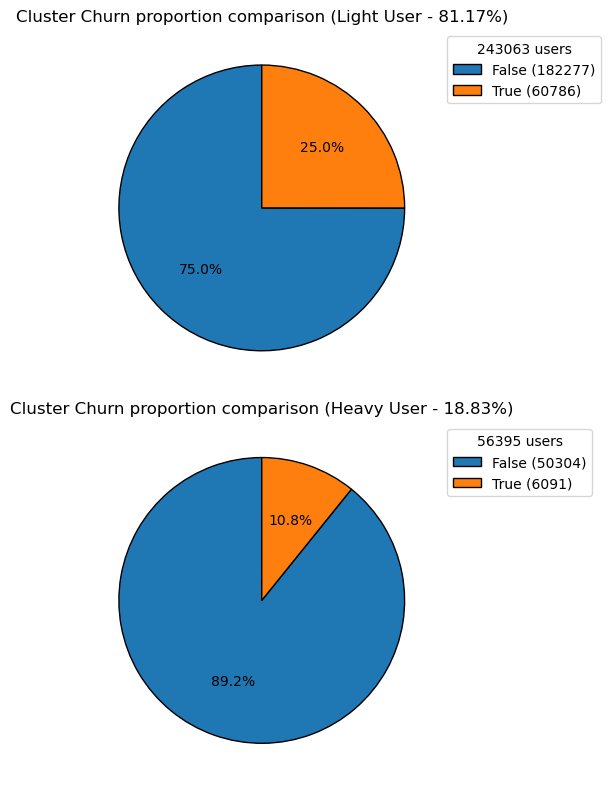

In [ ]:
def compare_cluster_is_churn_proportion(df: pd.DataFrame):
    cluster_value_map = get_cluster_value_map(df)

    n_rows = len(CLUSTERS)
    n_cols = 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 8))  # Adjust the figure size
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    cluster_counted = df['cluster'].value_counts()
    for index, cluster in enumerate(cluster_counted.index):
        filtered_df =  df[df['cluster'] == cluster]
        is_churn_counted = filtered_df['is_churn'].value_counts()

        cluster_percentage = len(filtered_df) * 100 / len(df)

        plot_pizza(
            value_counts=is_churn_counted,
            labels=[f'{x} ({is_churn_counted[x]})' for x in is_churn_counted.index],
            title=f'Cluster Churn proportion comparison ({cluster_value_map[cluster]} - {cluster_percentage:.2f}%)',
            legend=f'{len(filtered_df)} users',
            ax=axes[index],
            colors=['red', 'blue']
        )

    plt.tight_layout()
    plt.show()

compare_cluster_is_churn_proportion(usage_df)

# Conclusão
Podemos perceber 3 tipos de usuários:
- Usuários Casuais (usam menos a plataforma; são a grande maioria)
- Usuários Pesados (utilizam de forma intensa)

Quanto mais os usuários utilizam a plataforma, menos eles tendem a virar churn no futuro.

## Store this code

Cluster qty: 2
Cluster qty: 3
Cluster qty: 4


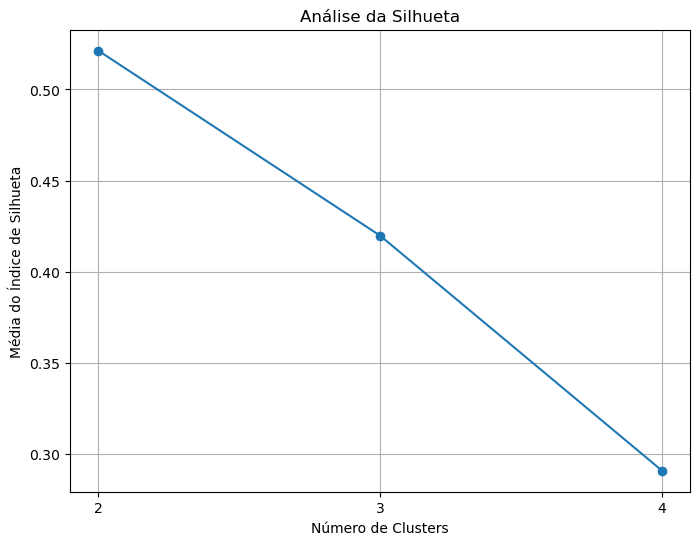

O número ideal de clusters é 2 com índice de silhueta médio de 0.52


In [34]:
# Utilizando o método da Silhueta, pois ele foca na qualidade dos agrupamentos
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

X = usage_df.copy()[USAGE_COLUMNS]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

range_n_clusters = list(range(2, 5))
silhouette_avg = []

for n_clusters in range_n_clusters:
    print(f'Cluster qty: {n_clusters}')
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg.append(silhouette_score(X_scaled, cluster_labels))

plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, silhouette_avg, marker='o')
plt.title("Análise da Silhueta")
plt.xlabel("Número de Clusters")
plt.ylabel("Média do Índice de Silhueta")
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

optimal_n_clusters = range_n_clusters[silhouette_avg.index(max(silhouette_avg))]
print(f"O número ideal de clusters é {optimal_n_clusters} com índice de silhueta médio de {max(silhouette_avg):.2f}")
